In [1]:
import pandas as pd
from collections import Counter
import datetime
import numpy as np
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# 特征选择

In [2]:
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import f1_score

In [3]:
import matplotlib.pyplot as plt

In [5]:
data1 = pd.read_csv('../Data/data1/data1.csv')
data2 = pd.read_csv('../Data/data2/data2.csv')
data3 = pd.read_csv('../Data/data3/data3.csv')

In [4]:
from sklearn.decomposition import PCA

In [6]:
drop_cols = ['login_sum','login_max','loginvar','loginmean','login_3_cnt','login_week_cnt','device_map'] + ['page_sum','page_0_sigle','page_1_sigle','page_2_sigle','page_3_sigle','page_4_sigle',
                 'action_type_sum','action_type_0_sigle','action_type_1_sigle','action_type_2_sigle',
                 'action_type_3_sigle','action_type_4_sigle','action_type_5_sigle']

data1 = data1[[c for c in data1.columns if c not in drop_cols]]
data2 = data2[[c for c in data2.columns if c not in drop_cols]]
data3 = data3[[c for c in data3.columns if c not in drop_cols]]

In [24]:
LGBM = lgb.LGBMClassifier(  max_depth=6,
                            n_estimators = 280,
                            learning_rate =0.05,     
                            objective = 'binary',
                            num_leaves=25,
                            boosting_type = 'dart',
#                             feature_fraction=0.5,
#                             lambda_l1=1,
#                             lambda_l2=0.5,
#                             subsample=0.7
)

In [13]:
train = pd.concat([data1, data2])
label  = train.pop('label')
train.pop('user_id')
test = data3.copy()
user_list = test.pop('user_id')
user_df = pd.DataFrame(user_list)
LGBM.fit(train[[c for c in train.columns if c in select_cols]], label)
user_df['pre_act'] = LGBM.predict_proba(test[[c for c in test.columns if c in select_cols]])[:,1]
user_pre = user_df[user_df.pre_act>0.4]['user_id']
print (len(user_pre))

26278


In [30]:
train = pd.concat([data1, data2])
label  = train.pop('label')
train.pop('device_type')
train.pop('user_id')
test = data3.copy()
test.pop('device_type')
user_list = test.pop('user_id')
user_df = pd.DataFrame(user_list)
pca = PCA(n_components=43,whiten=True, copy=True)
pca.fit(train)
pca_train = pca.transform(train)
# trainModel(pca_train, label)
LGBM.fit(pca_train, label)
pca_test = pca.transform(test)
user_df['pre_act'] = LGBM.predict_proba(pca_test)[:,1]
user_pre = user_df[user_df.pre_act>0.4]['user_id']
print (len(user_pre))


28985


In [31]:
user_pre.to_csv('../Output/resultC_drop.csv', index=False)

In [8]:
def sroceF1(pred, real):
    M = set(pred)
    N = set(real)
    Precision = len(M.intersection(N))/len(M)
    Recall = len(M.intersection(N))/len(N)
    F1 = 2*Precision*Recall/(Precision+Recall)

    print("Precision=",Precision,"| Recall=",Recall)
    print("F1=",F1)

In [9]:
def trainModelAndPredict(train_data, test_data, yuzhi=0.4, model=LGBM):
    train = train_data.copy()
    users = train.pop('user_id')
    label = train.pop('label')
    model.fit(train, label)
    
    test = test_data.copy()
    real_user = test[test.label==1]['user_id']
    test.pop('label')
    user_list = test.pop('user_id')
    user_df = pd.DataFrame(user_list)
    
    user_df['pre_act'] = model.predict_proba(test)[:,1]
    user_pre = user_df[user_df.pre_act>yuzhi]['user_id']
    sroceF1(user_pre, real_user)
        
    return model.feature_importances_, train.columns

In [10]:
def trainModelAllData(yuzhi=0.4, model=LGBM):
    train = pd.concat([data1, data2])
    train.pop('user_id')
    label = train.pop('label')
    model.fit(train, label)
    
    return model.feature_importances_, train.columns

# PCA 特征选择实现

In [16]:
data = pd.concat([data1, data2])
label  = data.pop('label')
data_temp = data[[c for c in data.columns if c not in ['user_id']]].values
# pca.fit(data_temp)
# pca_data = pca.transform(data_temp)
# fea_score = np.cumsum(pca.explained_variance_ratio_)
# len(fea_score[fea_score<1])

In [ ]:
def pcaIterModel(data_temp, label, yuzhi=0.4):
    for i in range(3,46):
        print (i)
        pca = PCA(n_components=i,whiten=True, copy=True)
        pca.fit(data_temp)
        pca_data = pca.transform(data_temp)
        trainModel(pca_data, label, yuzhi)

pcaIterModel(train, label)

# 模型训练结果importance选择特征

In [27]:
# data = pd.concat([data1, data2])
# data = data[[c for c in data.columns if c in  select_cols]]
trainModelAndPredict(data1, data2, model=LGBM)
feature_importances, columns_name = trainModelAllData(model=LGBM)

Precision= 0.7690281623556426 | Recall= 0.841735659373152
F1= 0.8037409564143285


In [28]:
feature_importances = 100 * (feature_importances / max(feature_importances))
feature_importances

array([  18.50443599,   63.878327  ,   82.00253485,    0.        ,
        100.        ,   45.12040558,   28.01013942,    0.        ,
         18.88466413,   74.90494297,    0.63371356,    1.0139417 ,
          0.38022814,    0.50697085,    1.26742712,    0.25348542,
          0.38022814,    2.0278834 ,    4.30925222,    2.40811153,
          0.        ,    0.88719899,    0.        ,   10.51964512,
         13.68821293,   21.54626109,   16.85678074,   17.61723701,
          9.63244613,   11.02661597,   20.27883397,   49.80988593,
         30.9252218 ,    0.        ,   34.22053232,    0.        ,
          0.25348542,    0.12674271,    0.        ,    0.25348542,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.38022814,    0.        ,    1.14068441,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

In [14]:
columns_name

Index(['register_day', 'register_type', 'device_type', 'login_day_max',
       'login_day_min', 'login_day_std', 'login_cnt', 'login_last_cnt',
       'login_3_arg_cnt', 'login_week_arg_cnt',
       ...
       'action_type_5_3_arg_cnt', 'action_type_5_7_cnt',
       'action_type_5_7_arg_cnt', 'action_type_0', 'action_type_1',
       'action_type_2', 'action_type_3', 'action_type_4', 'action_type_5',
       'is_author'],
      dtype='object', length=103)

In [30]:
print (len(feature_importances))
print (len(feature_importances[feature_importances>0]))

103
52


In [31]:
sorted_list = np.argsort(feature_importances)[::-1]

In [32]:
select_cols = columns_name[sorted_list[:52]]

In [33]:
select_cols

Index(['login_day_min', 'device_type', 'login_week_arg_cnt', 'register_type',
       'act_last_cnt', 'login_day_std', 'action_type_0', 'act_week_cnt',
       'page_1', 'act_3_cnt', 'login_cnt', 'page_0', 'act_day_std', 'actmean',
       'page_2', 'login_3_arg_cnt', 'register_day', 'act_sum', 'act_cnt',
       'action_type_1', 'action_type_2', 'act_day_min', 'actvar',
       'act_day_max', 'act_max', 'page_3', 'video_last_cnt', 'action_type_3',
       'page_4', 'video_3_cnt', 'videomean', 'video_sum', 'is_author',
       'page_3_7_cnt', 'action_type_1_7_cnt', 'video_day_min',
       'video_week_cnt', 'action_type_0_7_cnt', 'video_day_max', 'video_cnt',
       'videovar', 'action_type_2_7_cnt', 'page_3_3_cnt', 'video_day_std',
       'action_type_0_1_cnt', 'action_type_0_3_cnt', 'action_type_5',
       'action_type_1_3_cnt', 'page_0_1_cnt', 'video_max', 'page_0_7_cnt',
       'page_0_3_cnt'],
      dtype='object')

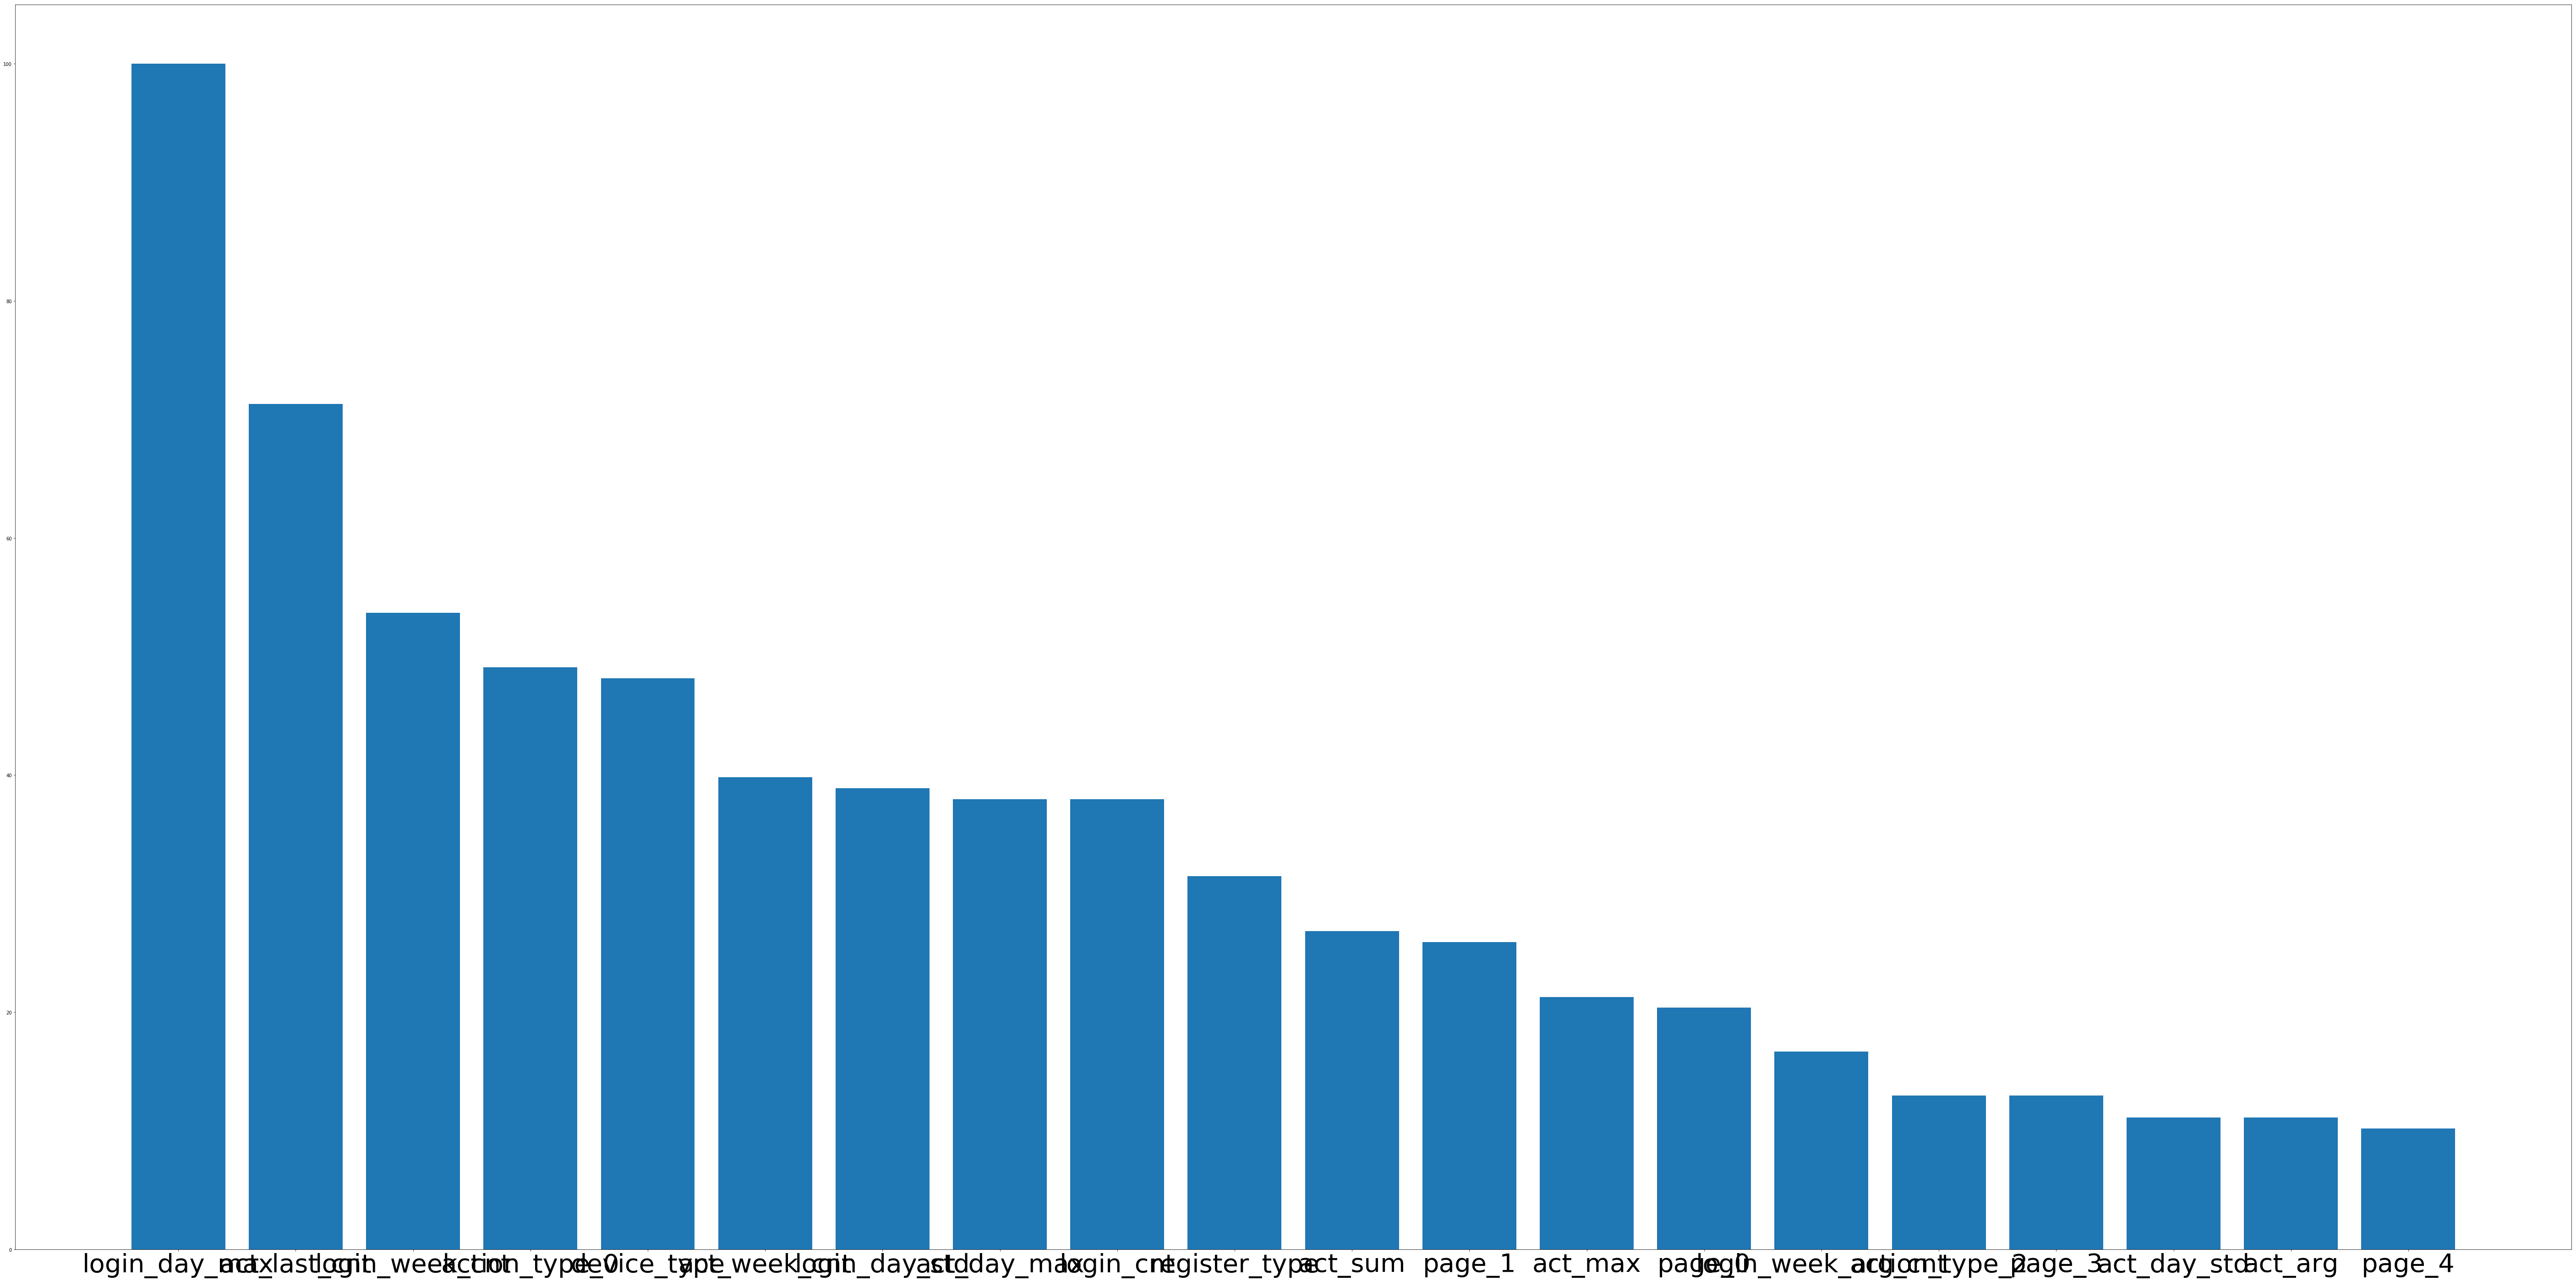

In [38]:
plt.figure(figsize=(100,50))
pos = np.arange(20) + 0.8 
plt.bar(pos, feature_importances[sorted_list][:20], align = 'center')
plt.xticks(pos, columns_name[sorted_list][:20], fontsize=56)
plt.show()

——————————————————————————————————————————————————————————